# **Bank Churn Prediction**

## Importamos librerías necesarias

In [1]:
# importemos las librerías básicas a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Lectura de datos

In [2]:
# cargamos dataset

df = pd.read_csv('datasets/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Revisamos tipo de datos y valores faltantes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Podemos quitar algunas columnas que no son necesarias para el proyecto, como el CustomerID, Surname y RowNumber

In [4]:
df.drop(columns = ['CustomerId', 'Surname', 'RowNumber'], inplace = True)

Convertiremos las columnas tipo object a tipo category

In [5]:
for column in df.columns:
  if df[column].dtype == np.dtype('object'):
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  int64   
 8   IsActiveMember   10000 non-null  int64   
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(7)
memory usage: 723.0 KB


Revisemos los valores categóricos para mirar si existen datos faltantes que estén expresadas de otra manera

In [6]:
for column in df.select_dtypes('category').columns:
  print(f'Valores únicos en variable {column}: {np.unique(df[column])}')


Valores únicos en variable Geography: ['France' 'Germany' 'Spain']
Valores únicos en variable Gender: ['Female' 'Male']


## Análisis de variables categóricas

Para mayor intepretabilidad en los análisis exploratorios, crearemos una variable que tome el valor "Yes" cuando la variable exited sea 1, y "No" cuando esta sea 0.

In [7]:
df['Exited_C'] = df.Exited.map({1:'Yes', 0:'No'})
df.drop(columns=['Exited'], inplace=True)

In [8]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited_C
0,619,France,Female,42,2,0.00,1,1,1,101348.88,Yes
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,No
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,Yes
3,699,France,Female,39,1,0.00,2,0,0,93826.63,No
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,No


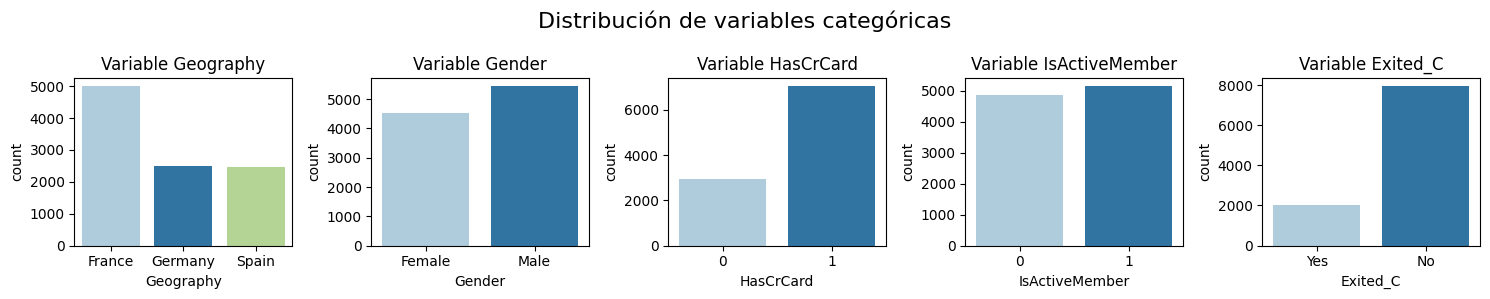

In [9]:
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited_C']
fig, axes = plt.subplots(1,5, figsize = (15,3))
fig.suptitle('Distribución de variables categóricas', fontsize=16)
for col, ax in zip(cat_cols, axes):
  ax.set_title('Variable '+col)
  sns.countplot(data = df, x = col, ax = ax, palette ='Paired')
plt.tight_layout()
plt.show()

Desde acá podemos concluir que el dataset contiene más créditos otorgados en Francia, hay mayoría de personas con tarjetas de crédito, y también se observa que la variable objetivo presenta un desbalanceo, lo cual puede ser un problema al momento de modelar.

## Análisis de variables numéricas

In [10]:
num_cols = df.drop(columns=cat_cols).columns.tolist()
df[num_cols].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


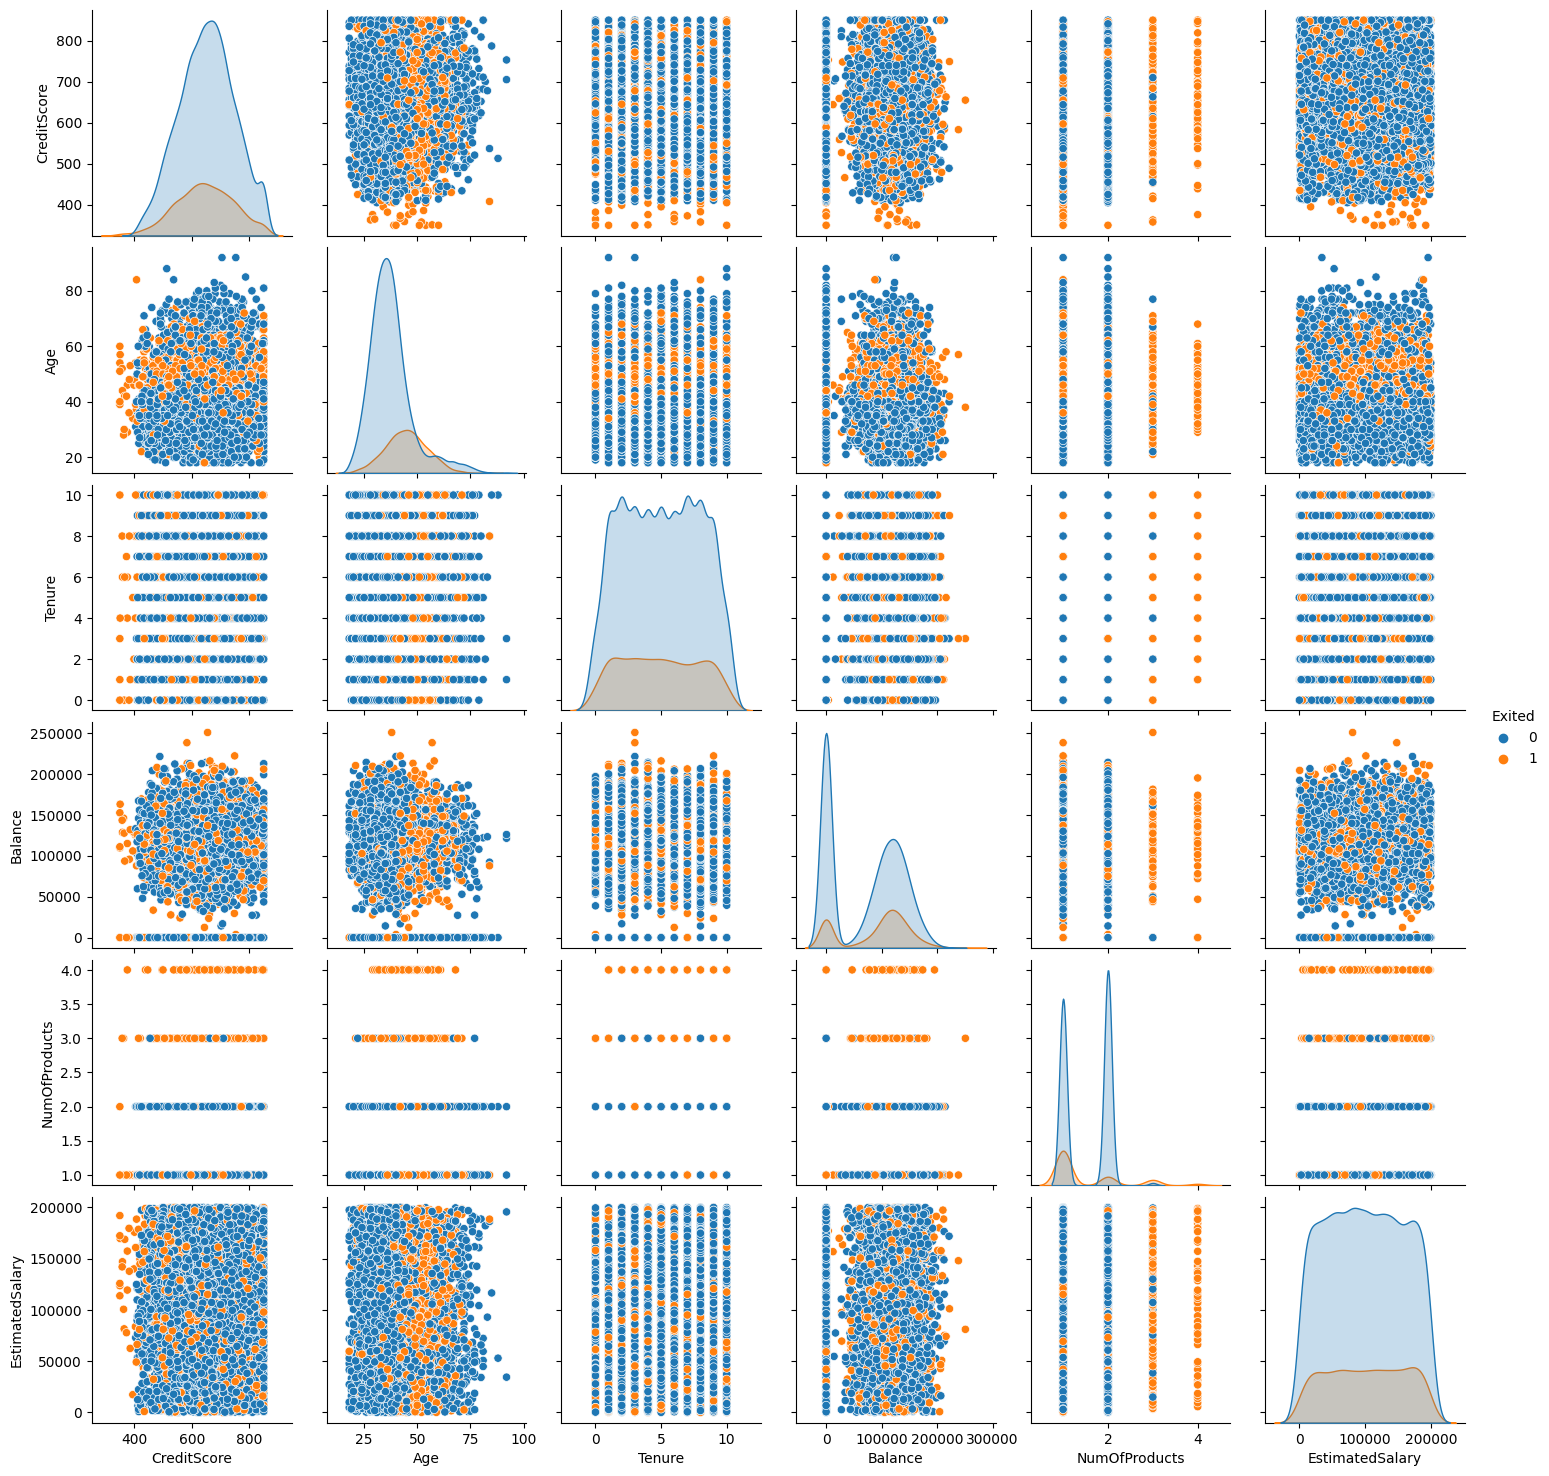

In [35]:
sns.pairplot(data=df, vars= num_cols, hue = 'Exited')
plt.show()

Los gráficos KDE (Kernel Density Estimate) de cada variable vs la variable respuesta son los gráficos de las diagonales, y de ahí podemos observar que la variable Age tiene cierto impacto con la variable objetivo al analizar pues parece que la media de edad de quienes no se retiran es menor a la de los que sí lo hacen, este puede verse en el siguiente diagrama de cajas:

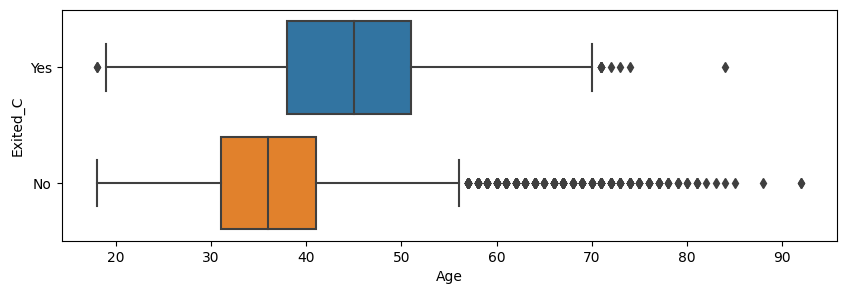

In [11]:
plt.figure(figsize=(10,3))
sns.boxplot(data= df, x = 'Age', y='Exited_C')
plt.show()

## Selección de características

### Correlación de variables numéricas

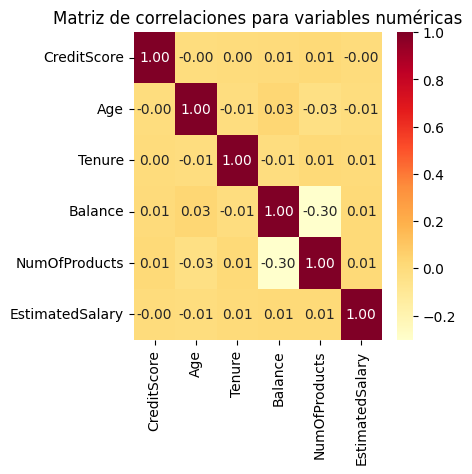

In [12]:
corr = df[num_cols].corr()
plt.figure(figsize=(4,4))
plt.title('Matriz de correlaciones para variables numéricas')
sns.heatmap(corr, annot=True, fmt = '.2f', cmap='YlOrRd')
plt.show()

No hay variables numéricas con correlaciones fuertes que deban ser eliminadas del dataset.

### Test f_classif para variables numéricas en problemas de clasificación:

- Hipótesis nula (H0): No hay diferencias significativas entre las medias de la variable de entrada en los diferentes grupos definidos por los valores de la variable target.
- Hipótesis alternativa (H1): Al menos una de las medias de la variable de entrada difiere significativamente entre los grupos definidos por los valores de la variable target.

Se rechaza H0 si valor p < 0.05 y se concluye que la variable contiene información relacionada con la variable objetivo

In [41]:
from sklearn.feature_selection import f_classif

X = df[num_cols]
y = df.Exited_C.values

f_test = f_classif(X,y)
pd.set_option('display.float_format', lambda x: '%.5f' % x) # para mostrar flotantes sin notación científica
f_test_df = pd.DataFrame(f_test, columns=num_cols).T.rename(columns = {0:'f1-score', 1:'p-value'}).sort_values(by = 'p-value', ascending=False)
f_test_df

,f1-score,p-value
EstimatedSalary,1.46326,0.22644
Tenure,1.96016,0.16153
CreditScore,7.34452,0.00674
NumOfProducts,22.91522,0.00000
Balance,142.47383,0.00000
Age,886.06327,0.00000


### Test Chi2 para variables categóricas en problemas de clasificación:

- Hipótesis nula (H0): La frecuencia observada de cada valor en las variables de entrada es igual para cada valor de la variable de salida.
- Hipótesis alternativa (H1): La frecuencia observada de cada valor en las variables de entrada es diferente para al menos un valor de la variable de salida.

Se rechaza la hipótesis nula si valor p < 0.05 y se concluye que hay relación significativa entre la variable de entrada categórica y la variable target categórica

In [57]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

# codificamos las variables categóricas
encoder = OrdinalEncoder()
X = df[cat_cols].drop(columns=['Exited_C'])
X = pd.DataFrame(encoder.fit_transform(X.values), columns = X.columns.tolist())
y = df.Exited_C.values

chi2_test = chi2(X,y)
pd.set_option('display.float_format', lambda x: '%.5f' % x) # para mostrar flotantes sin notación científica
chi2_test_df = pd.DataFrame(chi2_test, columns=X.columns.tolist()).T.rename(columns = {0:'f1-score', 1:'p-value'}).sort_values(by = 'p-value', ascending=False)
chi2_test_df

,f1-score,p-value
HasCrCard,0.15004,0.69850
Geography,11.85325,0.00058
Gender,51.53993,0.00000
IsActiveMember,118.19941,0.00000


## Guardamos el dataset limpio y preprocesado para modelar

In [61]:
df.to_csv('datasets/data_to_model.csv')